# SVM (Suppurt Vector Machine) - Banking Credit Cards Eligibility Prediction

#### The goal of this notebook is to use SVM classification model on banking dataset to classify the customers if they are eligible for credit card or not?

### Introduction of SVM

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors, and hence algorithm is termed as Support Vector Machine.

In [20]:
# Importing the necessary packages

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.svm import SVC

import warnings

warnings.filterwarnings("ignore")

### Downloading the dataset

In [21]:
# Helper function with dataset download on the go!

filename = "bank-data.csv"

def getDataset(filename, **kwargs):
    url = f"https://raw.githubusercontent.com/azizzoaib786/svm-banking-dataset/main/{filename}"
    try:
        if filename not in os.listdir():
            # Install wget if not already installed
            try:
                import wget
            except ImportError:
                !pip install wget
                import wget

            # Download the file
            wget.download(url, filename)
            print(f"\n{filename} file downloaded successfully.")
        else:
            print(f"{filename} already exists.")
        return pd.read_csv(filename, **kwargs)
    except Exception as e:
        print(e)
        return pd.read_csv(url, **kwargs)

data = getDataset(filename, encoding="unicode_escape")

bank-data.csv already exists.


### Feature Explanation

ID: Unique identifier

Age: Customer’s age

Experience: Number of years of profession experience

Income: Annual income of the customer ($000)

ZipCode: Home address zip code

Family: Family size of customer

CCAvg: Average spending on credit cards per month ($000)

Education: Education level (1) undergraduate, (2) graduate, (3) advanced/professional

Mortgage: Value of house mortgage ($000)

Personal Loan(y): Did the customer accept the personal load offered (1=Yes, 0=No)

Securities Account: Does the customer have a securities account with the bank? (1=Yes, 0=No)

CD Account: Does the customer have a certificate of deposit with the bank? (1=Yes, 0=No)

Online: Does the customer use Internet banking facilities (1=Yes, 0=No)

CreditCard: Does the customer use a credit card issued by Universal Bank? (1=Yes, 0=No)

### EDA on the dataset

In [22]:
# Check the head of the data
data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [23]:
# Check for null values
data.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [24]:
# Check for null values
data.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [25]:
# Check the statistics of the data
data.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [26]:
negative_experience = len(data[data['Experience'] < 0 ])
print(negative_experience)

52


##### Based on the above stats of our dataset, we are going to perform below processing on the dataset.

1. `ID` is the unique column and every customer has a unqiue value which is not required in our model training, so we are going to drop it.
2. `ZIP Code` is again the same feature which is based on the area and the building, we do not require this as well for our model training hence we are going to drop it.
3. `Experience` feature cannot have *negative* values, minimum value should be 0 but we can see that it has -3 and there are some entries with -1 and -2 as well. We are going to set them as 0 for all the negative values. In total 52 rows will be impacted.

In [27]:
# Set 0 for negative Experience values
data['Experience'] = data['Experience'].apply(lambda x : x if x > 0 else 0 )

# Drop ID and Zip Code from dataset
data.drop(['ID' , 'ZIP Code'] , axis=1 , inplace=True)

##### Finally we have the completed the EDA and now we are going to Visualize the data and perform further processing.

### Visualization of the Data

#### Heatmap

<Axes: title={'center': 'Heatmap showing Correlation between all the features'}>

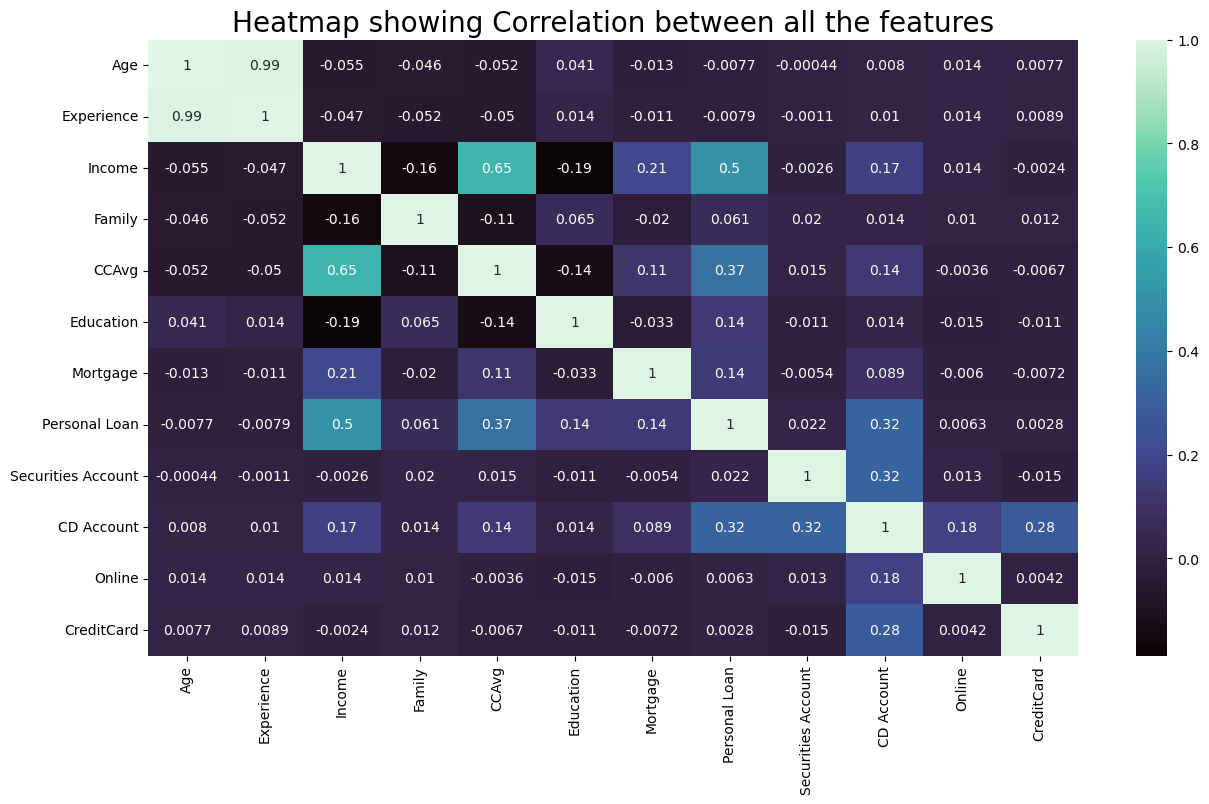

In [28]:
plt.figure(figsize=(15,8))
plt.title("Heatmap showing Correlation between all the features", fontsize=20)
sns.heatmap(data.corr(),annot = True, cmap='mako')

##### Based on the above coorelation matrix, I conclude below 2 points

1. There is no need to use PCA here as I do not see high coorelation between the features except `Experience` vs `Age`.
2. Samples are much larger than features, hence PCA is not required.

### Data Scaling

#### Standardization

In [29]:
# Scaling the data using StandardScaler
standard_scaler = StandardScaler()
scaled = standard_scaler.fit(data.drop('CreditCard',axis=1)).transform(data.drop('CreditCard',axis=1))
data_scaled = pd.DataFrame(scaled, columns=data.columns[:-1])

data_scaled.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online
0,-1.774417,-1.671390,-0.538229,1.397414,-0.193371,-1.049078,-0.555524,-0.325875,2.928915,-0.25354,-1.216618
1,-0.029524,-0.097873,-0.864109,0.525991,-0.250595,-1.049078,-0.555524,-0.325875,2.928915,-0.25354,-1.216618
2,-0.552992,-0.447543,-1.363793,-1.216855,-0.536720,-1.049078,-0.555524,-0.325875,-0.341423,-0.25354,-1.216618
3,-0.901970,-0.972049,0.569765,-1.216855,0.436103,0.141703,-0.555524,-0.325875,-0.341423,-0.25354,-1.216618
4,-0.901970,-1.059467,-0.625130,1.397414,-0.536720,0.141703,-0.555524,-0.325875,-0.341423,-0.25354,-1.216618


### Model Implementation

### SVM (Support Vector Machine)

In [30]:
# Splitting the columns in to dependent variable (x) and independent variable (y).

x = data_scaled
y = data['CreditCard']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

svc=SVC(kernel='linear') 
svc.fit(x_train, y_train)
y_pred=svc.predict(x_test)

print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("SVC f1-score  : {:.4f}".format(f1_score(y_pred, y_test)))
print("SVC precision : {:.4f}".format(precision_score(y_pred, y_test)))
print("SVC recall    : {:.4f}".format(recall_score(y_pred, y_test)))
print("\n", classification_report(y_pred, y_test))

Accuracy Score: 0.7630
SVC f1-score  : 0.3130
SVC precision : 0.1922
SVC recall    : 0.8438

               precision    recall  f1-score   support

           0       0.99      0.76      0.86       936
           1       0.19      0.84      0.31        64

    accuracy                           0.76      1000
   macro avg       0.59      0.80      0.58      1000
weighted avg       0.94      0.76      0.82      1000



##### Based on the above classification report we have average accuracy of 76% but f1, recall and precision is not good for 1s in the dataset. I'll try below methods to improve the accuracy score.

1. Hyperparameter search and use of different kernels
2. Use of SMOTE ((Synthetic Minority Oversampling Technique) process

#### Hyperparameter Search

##### Since I have large dataset, I'm going to take the 10% of the data and do the hyperparameter search on it because its going to kill my computer on 60K+ rows

In [31]:
#Use 20% of the data
x_small, _, y_small, _ = train_test_split(x_train, y_train, train_size=0.2)

# Find best parameters with SVC
kernels = list(["linear", "rbf", "poly", "sigmoid"])
c = list([0.001, 0.01, 0.1, 1])
gammas = list([0.1, 1])

svc = SVC()
svc.fit(x_train, y_train)


param_grid = dict(kernel=kernels, C=c, gamma=gammas)
grid = GridSearchCV(svc, param_grid, cv=10, n_jobs=-1)
grid.fit(x_small, y_small)
grid.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}

In [32]:
# After finding best hyper parameter, apply the model again
svc = SVC(C=0.1, gamma=0.1, kernel="poly")
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("SVC f1-score  : {:.4f}".format(f1_score(y_pred, y_test)))
print("SVC precision : {:.4f}".format(precision_score(y_pred, y_test)))
print("SVC recall    : {:.4f}".format(recall_score(y_pred, y_test)))
print("\n", classification_report(y_pred, y_test))

Accuracy Score: 0.7650
SVC f1-score  : 0.3109
SVC precision : 0.1886
SVC recall    : 0.8833

               precision    recall  f1-score   support

           0       0.99      0.76      0.86       940
           1       0.19      0.88      0.31        60

    accuracy                           0.77      1000
   macro avg       0.59      0.82      0.58      1000
weighted avg       0.94      0.77      0.83      1000



#### Even after hyperparameter search, no much difference in accuracy. Because of below imbalance in the dataset. I will now try the SMOTE process to improve the accuracy

In [33]:
y.value_counts()

CreditCard
0    3530
1    1470
Name: count, dtype: int64

### SMOTE (Synthetic Minority Oversampling Technique) process

In [34]:
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn
from imblearn.over_sampling import SMOTE

sms = SMOTE(random_state=42)
X_res, y_res = sms.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print("x_train Shape : ", x_train.shape)
print("x_test Shape  : ", x_test.shape)
print("y_train Shape : ", y_train.shape)
print("y_test Shape  : ", y_test.shape)

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imblearn 0.0
Uninstalling imblearn-0.0:
  Successfully uninstalled imblearn-0.0
  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-macosx_12_0_arm64.whl (8.4 MB)

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
x_train Shape :  (5648, 11)
x_test Shape  :  (1412, 11)
y_train Shape :  (5648,)
y_test Shape  :  (1412,)


In [35]:
# After SMOTE, basic method without any hyperparameter search
svc = SVC()
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("SVC f1-score  : {:.4f}".format(f1_score(y_pred, y_test)))
print("SVC precision : {:.4f}".format(precision_score(y_pred, y_test)))
print("SVC recall    : {:.4f}".format(recall_score(y_pred, y_test)))
print("\n", classification_report(y_pred, y_test))

Accuracy Score: 0.6027
SVC f1-score  : 0.6202
SVC precision : 0.6580
SVC recall    : 0.5864

               precision    recall  f1-score   support

           0       0.55      0.62      0.58       631
           1       0.66      0.59      0.62       781

    accuracy                           0.60      1412
   macro avg       0.60      0.60      0.60      1412
weighted avg       0.61      0.60      0.60      1412



#### Hyperparameter Search after SMOTE

In [36]:
#Use 20% of the data after the SMOTE process
x_small, _, y_small, _ = train_test_split(x_train, y_train, train_size=0.2)

# Find best parameters with SVC after SMOTE process
kernels = list(["linear", "rbf", "poly", "sigmoid"])
c = list([0.001, 0.01, 0.1, 1])
gammas = list([0.1, 1])

svc = SVC()
svc.fit(x_train, y_train)


param_grid = dict(kernel=kernels, C=c, gamma=gammas)
grid = GridSearchCV(svc, param_grid, cv=10, n_jobs=-1)
grid.fit(x_small, y_small)
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [37]:
# After finding best hyper parameter, apply the model again after the SMOTE process
svc = SVC(C=1, gamma=1, kernel="rbf")
svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("SVC f1-score  : {:.4f}".format(f1_score(y_pred, y_test)))
print("SVC precision : {:.4f}".format(precision_score(y_pred, y_test)))
print("SVC recall    : {:.4f}".format(recall_score(y_pred, y_test)))
print("\n", classification_report(y_pred, y_test))

Accuracy Score: 0.7075
SVC f1-score  : 0.7146
SVC precision : 0.7428
SVC recall    : 0.6884

               precision    recall  f1-score   support

           0       0.67      0.73      0.70       661
           1       0.74      0.69      0.71       751

    accuracy                           0.71      1412
   macro avg       0.71      0.71      0.71      1412
weighted avg       0.71      0.71      0.71      1412



### Final conclusion points

#### The SMOTE (Synthetic Minority Over-sampling Technique) process proved to be a very effective method for addressing class imbalance in our banking dataset. It helped in:

1. Balancing the Dataset
2. Improved Model Performance
3. Prevention of Overfitting

#### We can observe from above classification report that, f1, recall and precision has improved a lot.